In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psColor, bwLabel
import os

TRAIN_DIR = os.listdir(path='../data/treino')
DATA = [cv2.imread('../data/treino/' + image_path) for image_path in TRAIN_DIR]

print("number of images in training set:", len(DATA))
print("image shape:", DATA[0].shape)

number of images in training set: 14
image shape: (530, 706, 3)


In [3]:
def showImages(imageArray, titles):
    for i, img in enumerate(imageArray):
        cv2.imshow(titles[i], img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# esta função vai dar print dos valores BGR ao contrario porque o MatPlotLib é normal e usa RGB, 
# cuidado para ele não trocar os valores e a imagem ficar estranha
def pltImages(imageArray, titles, cmap = None):
    n_images = len(imageArray)
    for i, image in enumerate(imageArray):
        plt.subplot(n_images, 1, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(titles[i])

In [4]:
#1. Leitura de imagens

image= DATA[7]
print(type(image))
print(image.dtype)
print(image.shape)
showImages([image], ["Imagem Original"])

<class 'numpy.ndarray'>
uint8
(525, 706, 3)


In [5]:
# #2. Binarização 

# def binarizacao (image, tolerance):
#     """
#     Função para realizar a binarização da imagem de modo a destacar os objetos presentes na mesma.

#     Args:
#         -image (np.array): Array da imagem em RGB que representa a imagem a ser binarização.
#         -tolerance (int): Tolerância usada para calcular o range da componente Hue da cor de fundo da imagem. 

#     Returns:
#         -image_objects (np.array): Array da imagem RGB sem fundo.
#         -bin_image (np.array): Array da imagem binarizada.
    
#     """
    
#     image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
#     #Obter a range de cores do fundo
#     hist= cv2.calcHist(image_hsv, [0], None, [179], [0,179])
#     plt.plot(hist)
#     max_hue_idx= np.argmax(hist) #Obter o valor de hue que aparece mais na imagem
#     low_hue= np.array([max_hue_idx - tolerance, 40, 0])
#     high_hue= np.array([max_hue_idx + tolerance, 255, 255])
    
#     #Tirar background da imagem através dos ranges de hue dados
#     background_mask= cv2.inRange(image_hsv, low_hue, high_hue)
#     inverted_mask= 255 - background_mask
#     image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)
    
#     image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)
#     thresh, bin_image = cv2.threshold(image_gs, 0, 255, cv2.THRESH_OTSU)
#     return image_objects, bin_image

# image_objects, bin_image= binarizacao(image, 20)
# showImages([image_objects, bin_image], ["Imagem sem background", "Imagem Binarizada"])


In [6]:
#2. Binarização 

def binarizacao (image, tolerance):
    """
    Função para realizar a binarização da imagem de modo a destacar os objetos presentes na mesma.

    Args:
        -image (np.array): Array da imagem em RGB que representa a imagem a ser binarização.
        -tolerance (int): Tolerância usada para calcular o range da componente de azul da cor de fundo da imagem. 

    Returns:
        -image_objects (np.array): Array da imagem RGB sem fundo.
        -bin_image (np.array): Array da imagem binarizada.
    
    """
    
    #Obter a range de cores do fundo
    hist_blue= cv2.calcHist([image], [0], None, [256], [0,256])
    # plt.figure()
    # plt.plot(hist_blue)
    max_blue_value_idx= np.argmax(hist_blue) #Obter o valor de azul que aparece mais na imagem
    low_blue= max_blue_value_idx - tolerance
    high_blue= max_blue_value_idx + tolerance

    hist_green= cv2.calcHist([image], [1], None, [256], [0,256])
    # plt.figure()
    # plt.plot(hist_green)
    max_green_value_idx= np.argmax(hist_green) #Obter o valor de verde que aparece mais na imagem
    low_green= max_green_value_idx - 60
    high_green= max_blue_value_idx + 60

    hist_red= cv2.calcHist([image], [2], None, [256], [0,256])
    # plt.figure()
    # plt.plot(hist_red)
    max_red_value_idx= np.argmax(hist_red) #Obter o valor de vvermelho que aparece mais na imagem
    low_red= max_red_value_idx - 40
    high_red= max_red_value_idx + 40

    low_color= np.array([low_blue, low_green, low_red])
    high_color= np.array([high_blue, high_green, high_red])
    
    #Tirar background da imagem através dos ranges de cores dados
    background_mask= cv2.inRange(image, low_color, high_color)
    inverted_mask= 255 - background_mask
    image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)
    
    image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)
    thresh, bin_image = cv2.threshold(image_gs, 0, 255, cv2.THRESH_OTSU)
    return image_objects, bin_image

image_objects, bin_image= binarizacao(DATA[8], 110)
showImages([image_objects, bin_image], ["Imagem sem background", "Imagem Binarizada"])

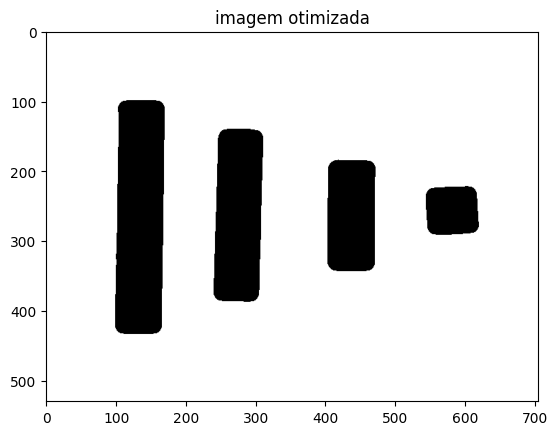

In [7]:
#3. melhoramento da imagem
def optimize_image(image):
    image_opt = image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    image_opt = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50))
    image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_ERODE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    # image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_CLOSE, kernel)
    image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_DILATE, kernel)
    return image_opt

image_opt = optimize_image(bin_image)
showImages([image_opt], ["Imagem apos melhoramento"])
pltImages([image_opt], ["imagem otimizada"], 'Greys')

In [8]:
# Construir targets
# Propriedades:
# area
# perimetro
# circ
# area_minarearect - area_real
# proporção

container_2x2 = []
container_2x4 = []
container_2x6 = []
container_2x8 = []
container_undef = []

TARGET_2x2 = []
TARGET_2x4 = []
TARGET_2x6 = []
TARGET_2x8 = []

In [9]:
def insert_in_container(img, container, contour_idx):
    contours = get_contours(img)
    
    for i in contour_idx:
        container.append(contours[i])
        
    # return container
        
def get_contours(img):

    _, bin_img = binarizacao(img, 110)
    opt_img = optimize_image(bin_img)

    contours, _ = cv2.findContours(opt_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def identify(img):
    bin_img = binarizacao(img, 110)[1]
    opt_img = optimize_image(bin_img)
    
    cnt_img = np.zeros((len(opt_img), len(opt_img[0]), 3))
    cnt_img[opt_img == 255] = [255, 255, 255]
    
    contours = get_contours(img)
    
    for i, contour in enumerate(contours):
        cv2.drawContours(cnt_img, [contour], 0, (0, 0, 255), thickness=5)
        showImages([cnt_img], [f"contour {i}"])
    
    return contours

In [56]:
# identify(DATA[0])
# Image 1
# 2x2: 0 7 8
# 2x4: 2 4 5
# 2x6:
# 2x8: 6
# undif: 1 3

insert_in_container(DATA[0], container_2x2, [0, 7, 8])
insert_in_container(DATA[0], container_2x4, [2, 4, 5])
insert_in_container(DATA[0], container_2x8, [6])
insert_in_container(DATA[0], container_undef, [1, 3])

# identify(DATA[1])
# Image 2
# 2x2: 4 5
# 2x4: 0 2
# 2x6: 
# 2x8: 3
# undif: 1

insert_in_container(DATA[1], container_2x2, [4, 5])
insert_in_container(DATA[1], container_2x4, [0, 2])
insert_in_container(DATA[1], container_2x8, [3])
insert_in_container(DATA[1], container_undef, [1])


# identify(DATA[2])
# Image 3
# 2x2: 0 2
# 2x4: 1
# 2x6:
# 2x8:
# undif:

insert_in_container(DATA[2], container_2x2, [0, 2])
insert_in_container(DATA[2], container_2x4, [1])

# identify(DATA[3])
# Image 4
# 2x2:
# 2x4: 0 1
# 2x6: 2
# 2x8: 3
# undif: 

insert_in_container(DATA[3], container_2x4, [0, 1])
insert_in_container(DATA[3], container_2x6, [2])
insert_in_container(DATA[3], container_2x8, [3])

# identify(DATA[4])
# # Image 5
# # 2x2:
# # 2x4: 1
# # 2x6:
# # 2x8: 2
# # undif: 0

insert_in_container(DATA[4], container_2x4, [1])
insert_in_container(DATA[4], container_2x8, [2])
insert_in_container(DATA[4], container_undef, [0])

# identify(DATA[5])
# Image 6
# 2x2:
# 2x4: 0 2
# 2x6:
# 2x8: 1
# undif:

insert_in_container(DATA[5], container_2x4, [0, 2])
insert_in_container(DATA[5], container_2x8, [1])

# identify(DATA[6])
# Image 7
# 2x2:
# 2x4:
# 2x6:
# 2x8:
# undif: 0 1 2

insert_in_container(DATA[6], container_undef, [0, 1, 2])

# identify(DATA[7])
# Image 8
# 2x2:
# 2x4: 0 1 
# 2x6: 2
# 2x8:
# undif: 3

insert_in_container(DATA[7], container_2x4, [0, 1])
insert_in_container(DATA[7], container_2x6, [2])
insert_in_container(DATA[7], container_undef, [3])

# identify(DATA[8])
# Image 9
# 2x2: 0
# 2x4: 1 
# 2x6: 2
# 2x8: 3
# undif:

insert_in_container(DATA[8], container_2x2, [0])
insert_in_container(DATA[8], container_2x4, [1])
insert_in_container(DATA[8], container_2x6, [2])
insert_in_container(DATA[8], container_2x8, [3])

# identify(DATA[9])
# Image 10
# 2x2: 0 1 2 3
# 2x4: 
# 2x6:
# 2x8:
# undif:

insert_in_container(DATA[9], container_2x2, [0, 1, 2, 3])

# identify(DATA[10])
# Image 11
# 2x2:
# 2x4: 0 1 2 3
# 2x6:
# 2x8: 
# undif:

insert_in_container(DATA[10], container_2x4, [0, 1, 2, 3])

# identify(DATA[11])
# Image 12
# 2x2: 
# 2x4: 
# 2x6: 
# 2x8: 0
# undif: 

insert_in_container(DATA[11], container_2x8, [0])

# identify(DATA[12])
# Image 13
# 2x2: 1
# 2x4: 0
# 2x6: 3 4
# 2x8:
# undif: 2 

insert_in_container(DATA[12], container_2x2, [1])
insert_in_container(DATA[12], container_2x4, [0])
insert_in_container(DATA[12], container_2x6, [3,4])
insert_in_container(DATA[12], container_undef, [2])

# identify(DATA[13])
# Image 14
# 2x2: 1
# 2x4: 0
# 2x6: 4
# 2x8:
# undif: 2 3 

insert_in_container(DATA[13], container_2x2, [1])
insert_in_container(DATA[13], container_2x4, [0])
insert_in_container(DATA[13], container_2x6, [4])
insert_in_container(DATA[13], container_undef, [2, 3])


In [57]:

def get_propriedades_container (container):
    
    props_container= np.zeros((len(container),5))
    for i, cnt in enumerate(container):
        props = np.ndarray([])
        area = cv2.contourArea(cnt)
        per = cv2.arcLength(cnt, True)
        circ = 4* np.pi * area / per **2
        min_rect_area = cv2.minAreaRect(cnt)
        width = min_rect_area[1][0]
        height = min_rect_area[1][1]
        delta = (width*height) - area
        propor = width / height
        # props = [area, per, circ, delta, width, height, propor]
        props = [area, per, circ, delta, propor]
        # props = [area, per, circ]
        props_container[i]= props
    return props_container

def get_estatistica_propriedades (vetor_props):
    media_props= np.mean(vetor_props, axis=0)
    desvio_props= np.std(vetor_props, axis=0)
    return media_props, desvio_props


# print(" AREA      PERIM     CIRC      WIDTH     HEIGHT    DELTA     PROPOR")
props_2x2= get_propriedades_container (container_2x2)
media_2x2, desvio_2x2= get_estatistica_propriedades (props_2x2)
# print(props_2x2)
# print(np.round(media_2x2, 1))
# print(np.round(desvio_2x2, 1))

# print(" AREA      PERIM     CIRC      WIDTH     HEIGHT    DELTA     PROPOR")
props_2x4= get_propriedades_container (container_2x4)
media_2x4, desvio_2x4= get_estatistica_propriedades (props_2x4)
# print(props_2x4)
# print(np.round(media_2x4, 1))
# print(np.round(desvio_2x4, 2))

# print(" AREA      PERIM     CIRC      WIDTH     HEIGHT    DELTA     PROPOR")
props_2x6= get_propriedades_container (container_2x6)
media_2x6, desvio_2x6= get_estatistica_propriedades (props_2x6)
# print(props_2x6)
# print(np.round(media_2x6, 1))
# print(np.round(desvio_2x6, 1))

# print(" AREA      PERIM     CIRC      WIDTH     HEIGHT    DELTA     PROPOR")
props_2x8= get_propriedades_container (container_2x8)
media_2x8, desvio_2x8= get_estatistica_propriedades (props_2x8)
# print(props_2x8)
# print(np.round(media_2x8, 1))
# print(np.round(desvio_2x8, 1))

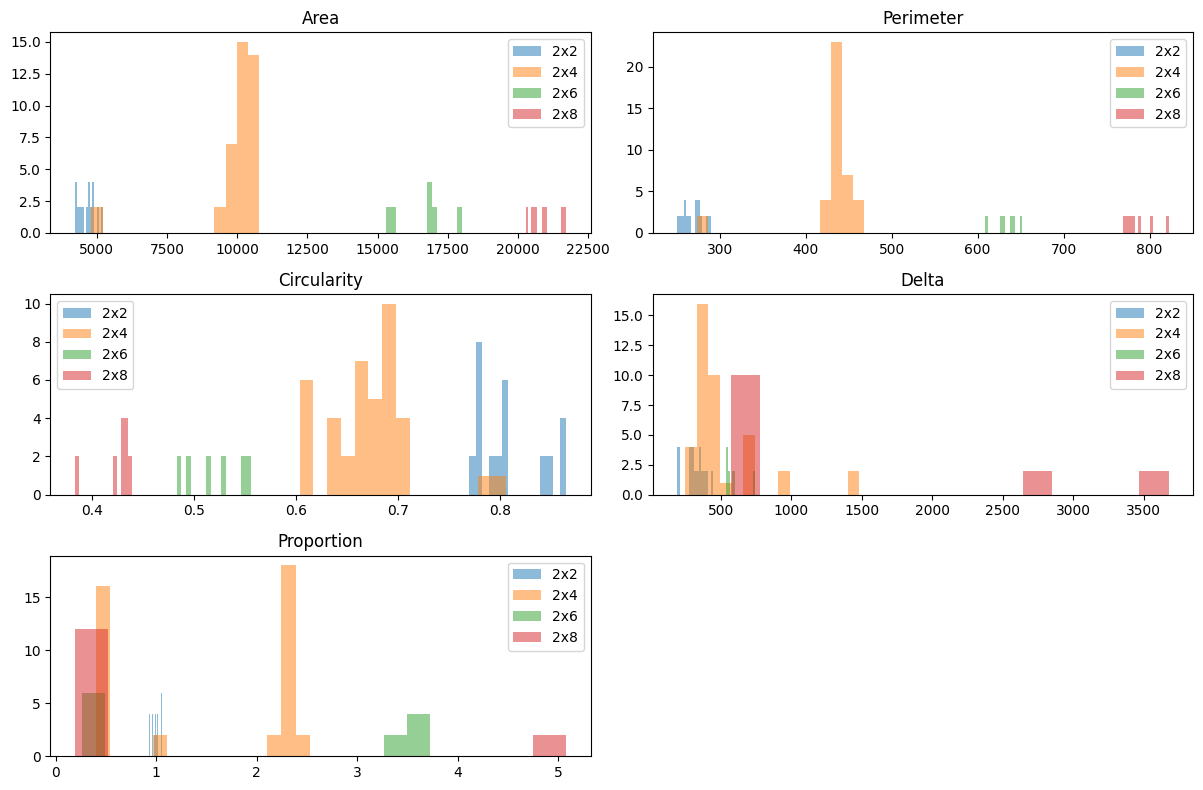

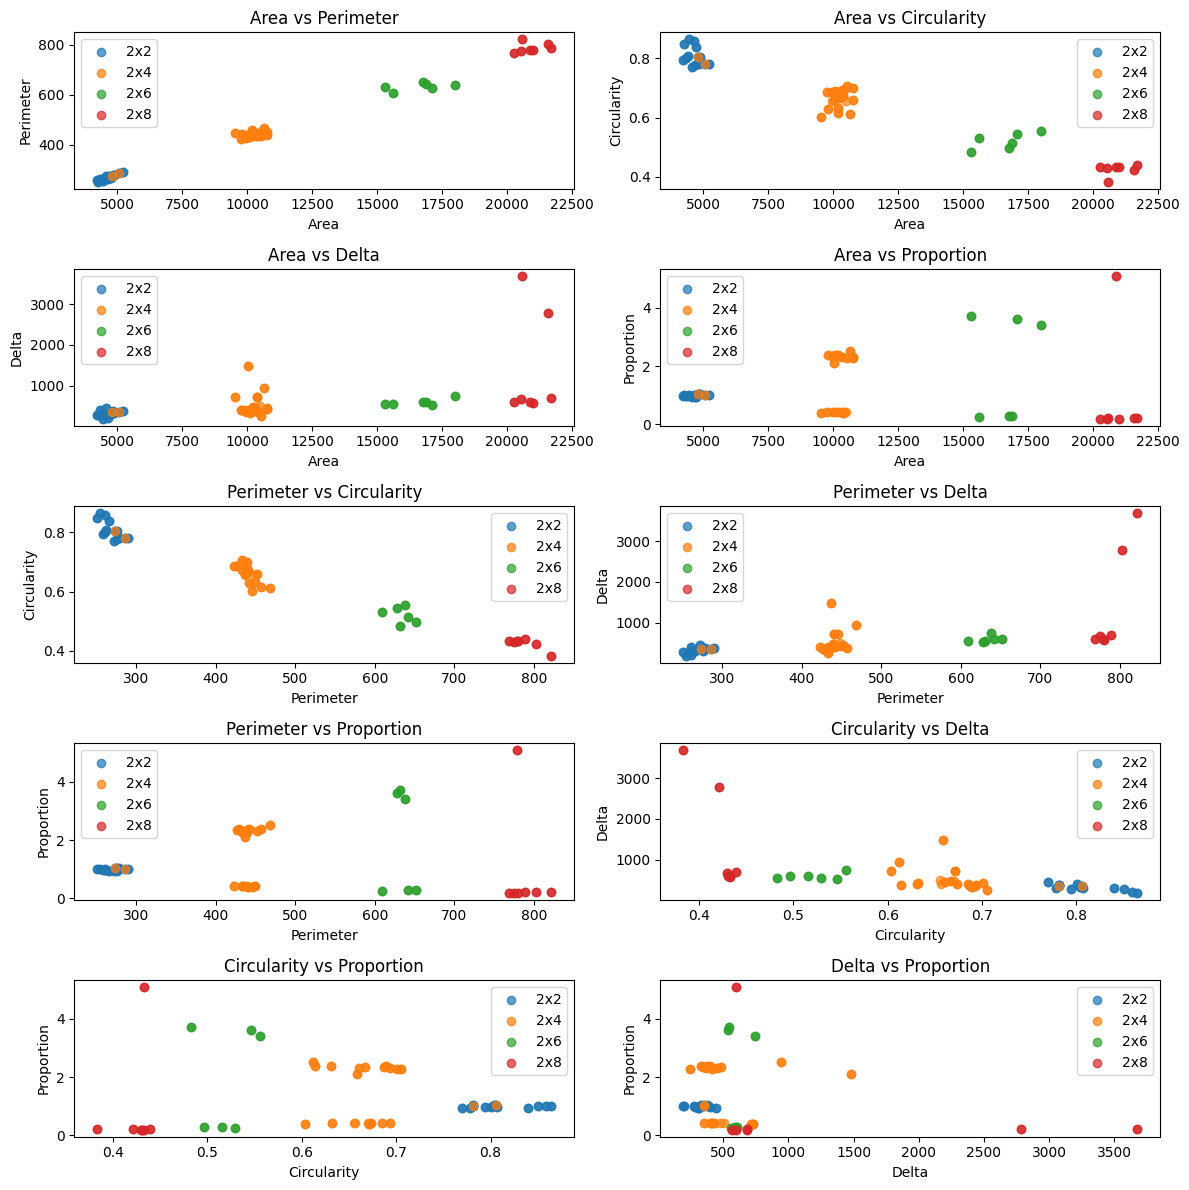

In [58]:
# Plot overlap of property distributions

plt.figure(figsize=(12, 8))
property_names = ['Area', 'Perimeter', 'Circularity', 'Delta', 'Proportion']
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.title(property_names[i])
    plt.hist(props_2x2[:, i], bins=15, alpha=0.5, label='2x2')
    plt.hist(props_2x4[:, i], bins=15, alpha=0.5, label='2x4')
    plt.hist(props_2x6[:, i], bins=15, alpha=0.5, label='2x6')
    plt.hist(props_2x8[:, i], bins=15, alpha=0.5, label='2x8')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot pairwise property scatter plots
plt.figure(figsize=(12, 12))
pair_indices = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
for i, (x_idx, y_idx) in enumerate(pair_indices):
    plt.subplot(5, 2, i + 1)
    plt.title(f'{property_names[x_idx]} vs {property_names[y_idx]}')
    plt.scatter(props_2x2[:, x_idx], props_2x2[:, y_idx], label='2x2', alpha=0.7)
    plt.scatter(props_2x4[:, x_idx], props_2x4[:, y_idx], label='2x4', alpha=0.7)
    plt.scatter(props_2x6[:, x_idx], props_2x6[:, y_idx], label='2x6', alpha=0.7)
    plt.scatter(props_2x8[:, x_idx], props_2x8[:, y_idx], label='2x8', alpha=0.7)
    plt.xlabel(property_names[x_idx])
    plt.ylabel(property_names[y_idx])
    plt.legend()
plt.tight_layout()
plt.show()

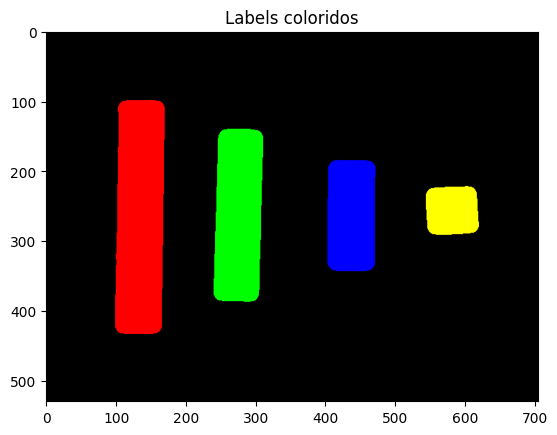

In [59]:
# Extração de componentes conexos

cc = cv2.connectedComponents(image_opt)

label_map = cc[1]

colored_image = np.zeros((image_opt.shape[0], image_opt.shape[1], 3), dtype=np.uint8)
colored_image[label_map == 1] = [255, 0, 0]
colored_image[label_map == 2] = [0, 255, 0]
colored_image[label_map == 3] = [0, 0, 255]
colored_image[label_map == 4] = [255, 255, 0]


showImages([colored_image], "contours")
pltImages([colored_image], ["Labels coloridos"])

In [60]:
#Extração de de propriedades

# Mati já te devo ter dito mas ya não consigo continuar se não tiver esta parte tua feita,
# usa a variavel cc lá de cima, a colored image é só para efeitos de display

# Na aula de hoje o prof tava a falar de reconhecimento de imagem com a cena dos centroides e tal, 
# e isso fez me pensar que ya, estas imagens são de treino porque nós vamos ter de literalmente treinar um modelo i think.
# That means we gonna have to think of how we can do that.
# Acho que variaveis de entrada seriam pelo menos a area e o perimetro, mas devem haver mais que conseguimos implementar.
# Vamos continuar a fazer isto tudo normalmente, mas deixa tudo o que é possiveis variaveis que identificam as peças (centroides de 
# area, perimetro, etc... para cada tipo diferente de peça) como inputs da tua função, o nosso modelo depois há de adaptar esses valores 
# com o treino que lhe dermos




In [61]:
# #Extração de de propriedades

# def extracao_propriedades (imagem_otimizada):
#     num_labels, label_map_stats, stats, centroides= cv2.connectedComponentsWithStats(imagem_otimizada) 
#     contours, hierarchy = cv2.findContours(imagem_otimizada, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    
#     propriedades= np.zeros((num_labels - 1, 10))
    
#     for i in range(1,num_labels): #Skip no índice 0 porque corresponde ao background
#         x= stats[i, cv2.CC_STAT_LEFT]
#         y= stats[i, cv2.CC_STAT_TOP]
#         width= stats[i, cv2.CC_STAT_WIDTH]
#         height= stats[i, cv2.CC_STAT_HEIGHT]
#         area= stats[i, cv2.CC_STAT_AREA]
#         #A indexação está a ser feita desta forma porque o array de contornos tem a ordem inversa do array de connected components
#         perimetro = cv2.arcLength(contours[len(contours) - i], True)  
#         circularidade= 4* np.pi * area / perimetro **2
#         rect = cv2.minAreaRect(contours[len(contours) - i])
        
#         vetor_propriedades= np.array([x, y, width, height, area, centroides[i][0], centroides[i][1], circularidade, rect[1][0], rect[1][1]])
#         propriedades[i-1]= vetor_propriedades
        
#     return propriedades

# propriedades_objectos= extracao_propriedades(image_opt)

# print(f"{propriedades_objectos[:,2]}")

In [ ]:
def extracao_propriedades (imagem_otimizada):
    contours, _ = cv2.findContours(imagem_otimizada, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    container= []
    for i in range(len(contours)):
        container.append(contours[i])
        
    return get_propriedades_container(container)

propriedades= extracao_propriedades(image_opt)
propriedades

array([[4.73850000e+03, 2.66325900e+02, 8.39506264e-01, 3.09091581e+02,
        9.27429367e-01],
       [1.04185000e+04, 4.34669046e+02, 6.92943191e-01, 3.54775143e+02,
        4.26083113e-01],
       [1.56115000e+04, 6.08811182e+02, 5.29284599e-01, 5.57163386e+02,
        2.64689371e-01],
       [2.17140000e+04, 7.88568541e+02, 4.38804227e-01, 6.86211651e+02,
        2.00022219e-01]])

In [63]:
# contours, hierarchy = cv2.findContours(image_opt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# cnt_image = np.zeros((525, 706, 3))
# cnt_image[image_opt == 255] = [255, 255, 255]

# cnt = contours[0]

# rect = cv2.minAreaRect(cnt)
# box = cv2.boxPoints(rect)
# box = np.int64(box)
# cnt_image = cv2.drawContours(cnt_image, [box], 0, (0,0,255), 2)
# area = cv2.contourArea(box)
# print(area)
# area_real = cv2.contourArea(cnt)
# print(area - area_real)

# cnt = contours[1]

# rect = cv2.minAreaRect(cnt)
# box = cv2.boxPoints(rect)
# box = np.int64(box)
# cnt_image = cv2.drawContours(cnt_image, [box], 0, (0,0,255), 2)
# area = cv2.contourArea(box)
# print(area)
# area_real = cv2.contourArea(cnt)
# print(area - area_real)


# showImages([cnt_image], ["test"])

In [64]:
# #Classificação de objetos

# def classificacao_objetos (propriedades, tolerancia_area= 10000):
#     respostas= np.zeros((len(propriedades), 2))
    
#     for i, vetor_prop in enumerate(propriedades):
#         minRectArea= vetor_prop[8] * vetor_prop[9]
#         area= vetor_prop[4]
#         if minRectArea - area < tolerancia_area:
#             width= vetor_prop[2]
#             height= vetor_prop[3]
#             if np.abs(height - width) < 10:
#                 respostas[i]= np.array([2,2])
#             else:
#                 cube_area= vetor_prop[8]**2
#                 if np.abs(cube_area * 2 - minRectArea) < tolerancia_area:
#                     respostas[i]= np.array([4,2])
#                 elif np.abs(cube_area * 3 - minRectArea) < tolerancia_area:
#                     respostas[i]= np.array([6,2])
#                 elif np.abs(cube_area * 4 - minRectArea) < tolerancia_area:
#                     respostas[i]= np.array([8,2])
            
#     return respostas

# resultados= classificacao_objetos (propriedades_objectos)
# print(resultados)

In [88]:
import dis
import scipy.spatial.distance as spd

# def classificacao_objetos (propriedades):
#     results= np.zeros((len(propriedades), 2))

#     for i, vetor_prop in enumerate(propriedades):
#         teste_prop= np.zeros(len(vetor_prop), dtype= np.int64)
#         for j, propriedade in enumerate(vetor_prop):
#             if propriedade >= (media_2x2[j] - desvio_2x2[j]) and propriedade <= (media_2x2[j] + desvio_2x2[j]):
#                 teste_prop[j]= 2
#             elif propriedade >= (media_2x4[j] - desvio_2x4[j]) and propriedade <= (media_2x4[j] + desvio_2x4[j]):
#                 teste_prop[j]= 4
#             elif propriedade >= (media_2x6[j] - desvio_2x6[j]) and propriedade <= (media_2x6[j] + desvio_2x6[j]):
#                 teste_prop[j]= 6
#             elif propriedade >= (media_2x8[j] - desvio_2x8[j]) and propriedade <= (media_2x8[j] + desvio_2x8[j]):
#                 teste_prop[j]= 8
#             # TODO: Try a distance to median approach?
#         print(teste_prop)
#         predict_class= np.bincount(teste_prop).argmax() #Descobrir a classe que corresponde mais propriedades do objeto
#         results[i]= np.array([2, predict_class])
#     return results

def distance_based_classification(propriedades):
    results = np.zeros((len(propriedades), 2))
    
    desvio_dict = {
        2: desvio_2x2,
        4: desvio_2x4,
        6: desvio_2x6,
        8: desvio_2x8
    }
    
    for i, vetor_prop in enumerate(propriedades):
        distances = {
            2: spd.euclidean(vetor_prop, media_2x2),
            4: spd.euclidean(vetor_prop, media_2x4),
            6: spd.euclidean(vetor_prop, media_2x6),
            8: spd.euclidean(vetor_prop, media_2x8)
        }
        print(distances)
        predict_class = min(distances, key=distances.get)
        results[i] = np.array([2, predict_class])
        
    return results

print(propriedades.shape)

# predict_classes= classificacao_objetos(propriedades)
predict_classes= distance_based_classification(propriedades)
predict_classes

(4, 5)
{2: 89.16725348648691, 4: 5227.313571361251, 6: 11883.937985097848, 8: 16248.796118655448}
{2: 5770.688574836838, 4: 486.3598480613964, 6: 6202.6658743494845, 8: 10580.519436120765}
{2: 10969.00688640033, 4: 5655.279178928074, 6: 1002.8439532960018, 8: 5397.411702593046}
{2: 17075.51263446135, 4: 11761.513721911071, 6: 5103.848647772958, 8: 1030.5593442305662}


array([[2., 2.],
       [2., 4.],
       [2., 6.],
       [2., 8.]])

In [76]:
#Teste

#Resultados pretendidos:
#2x4
#2x4
#2x6
#Undef

imagem_teste= DATA[7]
showImages([imagem_teste], ["Imagem Original"])

imagem_teste_objects, bin_imagem_teste= binarizacao(imagem_teste, 110)
showImages([imagem_teste_objects, bin_imagem_teste], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste_opt = optimize_image(bin_imagem_teste)
showImages([imagem_teste_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste= extracao_propriedades(imagem_teste_opt)
# print(propriedades_objectos_teste)
# resultados_teste= classificacao_objetos (propriedades_objectos_teste)
resultados_teste = distance_based_classification(propriedades_objectos_teste)
print(resultados_teste)

[[2. 4.]
 [2. 4.]
 [2. 0.]
 [2. 0.]]


In [77]:
#Teste

#Resultados pretendidos:
#Undef
#2x4
#2x8

imagem_teste2= DATA[4]
showImages([imagem_teste2], ["Imagem Original"])

imagem_teste2_objects, bin_imagem_teste2= binarizacao(imagem_teste2, 110)
showImages([imagem_teste2_objects, bin_imagem_teste2], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste2_opt = optimize_image(bin_imagem_teste2)
showImages([imagem_teste2_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste2= extracao_propriedades(imagem_teste2_opt)
# resultados_teste2= classificacao_objetos (propriedades_objectos_teste2)
resultados_teste2 = distance_based_classification(propriedades_objectos_teste2)
print(resultados_teste2)

[[2. 0.]
 [2. 4.]
 [2. 0.]]


In [78]:
#Teste

#Resultados pretendidos:
#2x2
#Undef
#2x4
#Undef
#2x4
#2x4
#2x8
#2x2
#2x2

imagem_teste3= DATA[0]
showImages([imagem_teste3], ["Imagem Original"])

imagem_teste3_objects, bin_imagem_teste3= binarizacao(imagem_teste3, 110)
showImages([imagem_teste3_objects, bin_imagem_teste3], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste3_opt = optimize_image(bin_imagem_teste3)
showImages([imagem_teste3_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste3= extracao_propriedades(imagem_teste3_opt)
# resultados_teste3= classificacao_objetos (propriedades_objectos_teste3)
resultados_teste3 = distance_based_classification(propriedades_objectos_teste3)
print(resultados_teste3)

[[2. 2.]
 [2. 0.]
 [2. 4.]
 [2. 0.]
 [2. 4.]
 [2. 4.]
 [2. 8.]
 [2. 0.]
 [2. 2.]]


In [80]:
#Teste

#Resultados pretendidos:
#2x4
#2x4
#2x6
#2x8

imagem_teste4= DATA[3]
showImages([imagem_teste4], ["Imagem Original"])

imagem_teste4_objects, bin_imagem_teste4= binarizacao(imagem_teste4, 110)
showImages([imagem_teste4_objects, bin_imagem_teste4], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste4_opt = optimize_image(bin_imagem_teste4)
showImages([imagem_teste4_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste4= extracao_propriedades(imagem_teste4_opt)
# resultados_teste4= classificacao_objetos (propriedades_objectos_teste4)
resultados_teste4 = distance_based_classification(propriedades_objectos_teste4)
print(resultados_teste4)

[[2. 4.]
 [2. 4.]
 [2. 6.]
 [2. 8.]]


In [81]:
#Teste

#Resultados pretendidos:
#2x4
#2x2
#Undef
#2x6
#2x6

imagem_teste5= DATA[12]
showImages([imagem_teste5], ["Imagem Original"])

imagem_teste5_objects, bin_imagem_teste5= binarizacao(imagem_teste5, 110)
showImages([imagem_teste5_objects, bin_imagem_teste5], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste5_opt = optimize_image(bin_imagem_teste5)
showImages([imagem_teste5_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste5= extracao_propriedades(imagem_teste5_opt)
# resultados_teste5= classificacao_objetos (propriedades_objectos_teste5)
resultados_teste5 = distance_based_classification(propriedades_objectos_teste5)
print(resultados_teste5)

[[2. 4.]
 [2. 2.]
 [2. 0.]
 [2. 0.]
 [2. 6.]]
